# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# < Перенесите сюда исследовательский анализ данных >
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Просмотрим график распределения возраста в выборке

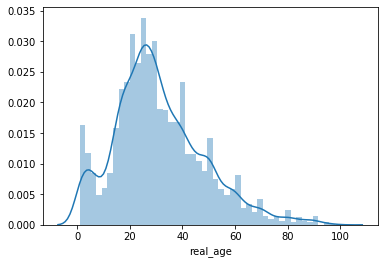

In [4]:
sns.distplot(labels['real_age'])
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

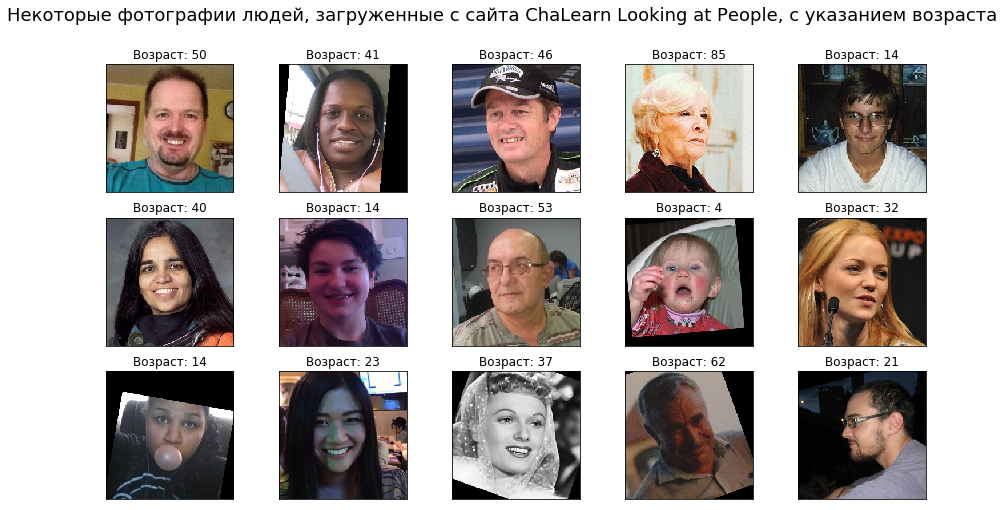

In [6]:
features, target = next(train_gen_flow)
# выведим на экран 15 изображений
fig = plt.figure(figsize=(15,8))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    
fig.suptitle('Некоторые фотографии людей, загруженные с сайта ChaLearn Looking at People, '
             'с указанием возраста', fontsize=18)
plt.show()

Датасет фотографий людей с указанием возраста содержит данные ~7600 изображений людей женского и мужского пола, различных возрастных групп и расы. В наборе данных имеются как цветные, так и черно-белые изображения людей под разным ракурсом.

# 2. Обучение модели

Перенесем код обучения модели и её результат вывода на экран.
(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale = 1./255,
        horizontal_flip=True,
        vertical_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

#
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 160s - loss: 225.2105 - mae: 11.0800 - val_loss: 497.1217 - val_mae: 17.1806
Epoch 2/5
356/356 - 41s - loss: 110.9984 - mae: 8.0394 - val_loss: 164.9621 - val_mae: 9.8048
Epoch 3/5
356/356 - 41s - loss: 89.9565 - mae: 7.1937 - val_loss: 280.5770 - val_mae: 13.9301
Epoch 4/5
356/356 - 41s - loss: 73.1421 - mae: 6.5295 - val_loss: 113.1763 - val_mae: 8.2851
Epoch 5/5
356/356 - 42s - loss: 60.8024 - mae: 5.9760 - val_loss: 81.1004 - val_mae: 6.7483


119/119 - 10s - loss: 81.1004 - mae: 6.7483
Test MAE: 6.7483

```

# 3. Анализ обученной модели

На основе набора фотографий людей с указанием возраста построена и обучена свёрточная нейронная сеть, определяющая по фотографии приблизительный возраст человека. Найдено, что для созданной модели значение метрики MAE - среднее абсолютное отклонение - на тестовой выборке составляет **~6.7**.

Внедрение компьютерного зрения для опеределения возраста клиентов направлено на решение следующих задач:
    
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.
    
Качество модели, метрика MAE ~6.7, позволяет решать первую задачу, с достаточной точностью может определить возрастную группу покупателей для продвижения некоторых товаров. Стоит учесть, что если возраст покупателей младше 10, скорее данная категория относится не к самостоятельным покупателям, а к детям, пришедшим со своими родителями и в этом случае нужно предлагать товары, которые заинтересуют и детей, и родителей. Для решения второй задачи качество предсказания недостаточно, что по-видимому, связано с трудностью точно определить возраст человека, так как внешность не сильно меняется в пределах плюс минус несколько лет.